In [115]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [117]:
#FIRST CONVERTING THE FILE TO CSV AND UPLOADED TO RUNTIME
df_rev = pd.read_csv('RETAIL_REVIEWS.csv')
df_rev.head()

,Sno.,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Now let’s clean it, dropping NaN values and removing useless columns, as well as clean the text.

In [118]:
df_rev.dropna(inplace=True)
df_rev.reset_index(drop=True, inplace=True)
import re
for i in range(len(df_rev)):
    #print(i)
    df_rev['Review Text'][i] = df_rev['Review Text'][i].replace("'s", " is").replace("'ll", " will").replace("'ve", " have").replace("'m", " am").replace("\'", "'")
    
df_rev['Review Text'][1]
df_rev.head()

,Sno.,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it is fun, f...",5,1,0,General Petite,Bottoms,Pants
2,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [119]:
# LEt first see the dimensions of data
df_rev.shape

(19662, 11)

In [120]:
#extracting only important imformation
df_imp = df_rev[['Review Text','Rating','Class Name','Age']]
df_imp.head()

,Review Text,Rating,Class Name,Age
0,I had such high hopes for this dress and reall...,3,Dresses,60
1,"I love, love, love this jumpsuit. it is fun, f...",5,Pants,50
2,This shirt is very flattering to all due to th...,5,Blouses,47
3,"I love tracy reese dresses, but this one is no...",2,Dresses,49
4,I aded this in my basket at hte last mintue to...,5,Knits,39


In [121]:
#check missing values
df_imp.isnull().sum()

Review Text    0
Rating         0
Class Name     0
Age            0
dtype: int64

Adding the Word Counts to the Dataframe and Finding out How Many Times Some Words Were Used

In [122]:
# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df_imp['Word Counts'] = df_imp['Review Text'].apply(wordcounts)
df_imp.head()

,Review Text,Rating,Class Name,Age,Word Counts
0,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
1,"I love, love, love this jumpsuit. it is fun, f...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
2,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."
3,"I love tracy reese dresses, but this one is no...",2,Dresses,49,"{'0p': 1, 'alterations': 1, 'am': 1, 'and': 4,..."
4,I aded this in my basket at hte last mintue to...,5,Knits,39,"{'aded': 1, 'all': 1, 'am': 1, 'and': 3, 'as':..."


Adding the word counts to a dataframe is a very good practice because we might use these counts to reach some useful information. To do this, I defined the function wordcounts.

Demonstrating the Densities of Class Names, Some Selected Words and All Words in the Reviews By Using WordCloud

Selected Words
love     7728
great    5306
super    1501
happy     623
glad      530
dtype: int64

Class Names
Dresses     5371
Knits       3981
Blouses     2587
Sweaters    1218
Pants       1157
Name: Class Name, dtype: int64


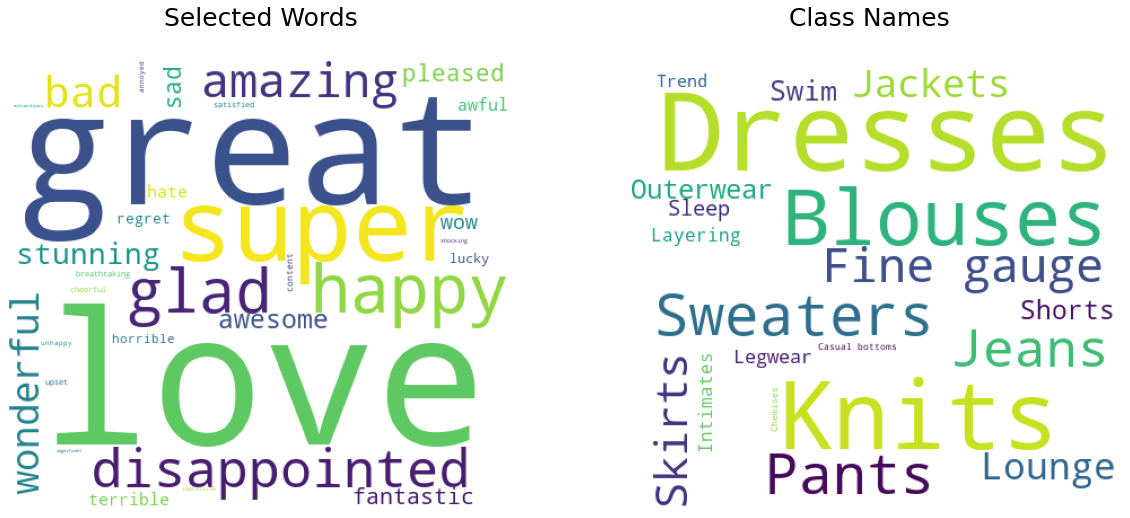

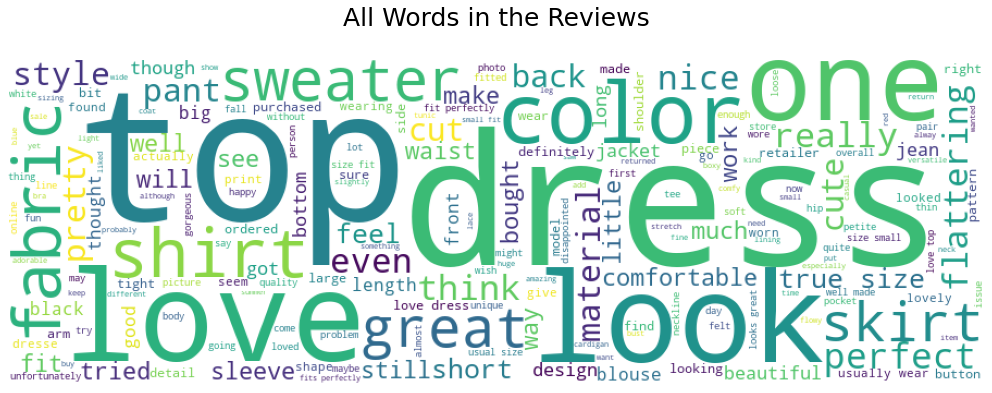

In [123]:
# selecting some words to examine detailed 
selectedwords = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

def selectedcount(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0
    
dfwc = df_imp.copy()  
for word in selectedwords:
    dfwc[word] = dfwc['Word Counts'].apply(selectedcount,args=(word,))
    
word_sum = dfwc[selectedwords].sum()
print('Selected Words')
print(word_sum.sort_values(ascending=False).iloc[:5])

print('\nClass Names')
print(df_imp['Class Name'].fillna("Empty").value_counts().iloc[:5])

fig, ax = plt.subplots(1,2,figsize=(20,10))
wc0 = WordCloud(background_color='white',
                      width=450,
                      height=400 ).generate_from_frequencies(word_sum)

cn = df_imp['Class Name'].fillna(" ").value_counts()
wc1 = WordCloud(background_color='white',
                      width=450,
                      height=400 
                     ).generate_from_frequencies(cn)

ax[0].imshow(wc0)
ax[0].set_title('Selected Words\n',size=25)
ax[0].axis('off')

ax[1].imshow(wc1)
ax[1].set_title('Class Names\n',size=25)
ax[1].axis('off')

rt = df_imp['Review Text']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

In [124]:
#Create new dataframe that only contains 5-star and 1-star reviews

df_best_worst = df_imp[(df_imp.Rating==5) | (df_imp.Rating==1)]
df_best_worst.head()

,Review Text,Rating,Class Name,Age,Word Counts
1,"I love, love, love this jumpsuit. it is fun, f...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
2,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."
4,I aded this in my basket at hte last mintue to...,5,Knits,39,"{'aded': 1, 'all': 1, 'am': 1, 'and': 3, 'as':..."
6,I love this dress. i usually get an xs but it ...,5,Dresses,24,"{'an': 1, 'and': 1, 'bust': 1, 'but': 1, 'dres..."
7,"I am 5""5' and 125 lbs. i ordered the s petite ...",5,Dresses,34,"{'125': 1, '34b': 1, 'am': 1, 'an': 1, 'and': ..."


In [125]:
#define X and y
#X is the review comment and based on X the person giving a status Y = good or bad
df_best_worst.rename(columns={"Review Text": "Review"}, inplace = True);
X = df_best_worst.Review
y = df_best_worst.Rating

In [126]:
#Split the new dataframe into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [127]:
X_train.head()

6911     This shirt is true to size. it has beautiful d...
18650    I love this tee so much i bought in every colo...
14627    Love this sweater so much that i am going to o...
19240    Great basic skirt to have.  it flows beautiful...
15513    I ordered this in the lavender and love the ri...
Name: Review, dtype: object

In [128]:
y_train.head()

6911     5
18650    5
14627    5
19240    5
15513    5
Name: Rating, dtype: int64

In [129]:
#use CountVectorizer to create document term matrix from X_train and X_test
vect=CountVectorizer()

In [130]:
X_train_dtm=vect.fit_transform(X_train)
X_train_dtm

<8661x9450 sparse matrix of type '<class 'numpy.int64'>'
	with 373217 stored elements in Compressed Sparse Row format>

In [131]:
X_test_dtm=vect.transform(X_test)
X_test_dtm

<2888x9450 sparse matrix of type '<class 'numpy.int64'>'
	with 121512 stored elements in Compressed Sparse Row format>

In [132]:
#rows are documents, columns are terms (aka "tokens" and "features")
X_train_dtm.shape

(8661, 9450)

In [133]:
#last 50 features
print(vect.get_feature_names()[-50:])

['years', 'yellow', 'yellowed', 'yellowish', 'yellows', 'yellowy', 'yep', 'yepeee', 'yes', 'yest', 'yesterday', 'yet', 'yfit', 'yield', 'yikes', 'yo', 'yoga', 'yogini', 'yogis', 'yoke', 'yolk', 'york', 'you', 'young', 'younger', 'your', 'yours', 'yourself', 'yourselves', 'youth', 'youthful', 'youthfull', 'yr', 'yrs', 'yuck', 'yummiest', 'yummy', 'zara', 'zero', 'zip', 'ziploc', 'zipped', 'zipper', 'zippered', 'zippers', 'zippie', 'zipping', 'zips', 'zone', 'zoom']


In [134]:
#show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [135]:
#include 1 grams and 2 grams
vect=CountVectorizer(ngram_range=(1,2))
X_train_dtm=vect.fit_transform(X_train)
X_train_dtm.shape

(8661, 126661)

In [136]:
#last 50 features
print(vect.get_feature_names()[-50:])

['zipper running', 'zipper snagging', 'zipper so', 'zipper sticks', 'zipper style', 'zipper that', 'zipper the', 'zipper this', 'zipper to', 'zipper took', 'zipper up', 'zipper was', 'zipper works', 'zipper would', 'zipper you', 'zippered', 'zippered pockets', 'zippered sweatshirt', 'zippers', 'zippers are', 'zippers at', 'zippers but', 'zippers buttons', 'zippers from', 'zippers got', 'zippers in', 'zippers on', 'zippers one', 'zippers opened', 'zippers or', 'zippers why', 'zippie', 'zippie love', 'zipping', 'zipping and', 'zipping it', 'zipping up', 'zipping with', 'zips', 'zips all', 'zips both', 'zips but', 'zips in', 'zips up', 'zone', 'zone as', 'zone since', 'zone very', 'zoom', 'zoom in']


Predicting the Star Rating

In [137]:
#use default options for CountVectorizer
#vect=CountVectorizer()
#As we increase the n-gram the accuracy decreases because it is difficult to find 3 consecutive words than 2 consecutive words
vect=CountVectorizer(ngram_range=(1,2))#Accuracy is 85.42%
#vect=CountVectorizer(ngram_range=(1,3))#Accuarcy is 83%

#create document-term matrices
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)

#use Naive Bayes to predict the star rating
nb=MultinomialNB()
nb.fit(X_train_dtm,y_train)
y_pred_class=nb.predict(X_test_dtm)
y_pred_class
#calculate accuracy
print(metrics.accuracy_score(y_test,y_pred_class))

0.9425207756232687


In [138]:
#calculate null accuracy- You should have assigned 1 but you have assigned 0
y_test_binary=np.where(y_test==5,1,0)
y_test_binary.mean()

0.9425207756232687

In [140]:
#define a function that accepts a vectorizer and calculates the accuracy
#this is y=f(x) it is a user defined function where all the mathematics done previously is stored
def tokenize_test(vect):
  X_train_dtm=vect.fit_transform(X_train)
  print('Features:',X_train_dtm.shape[1])
  X_test_dtm=vect.transform(X_test)
  nb=MultinomialNB()
  nb.fit(X_train_dtm,y_train)
  y_pred_class=nb.predict(X_test_dtm)
  print('Accuracy:',metrics.accuracy_score(y_test,y_pred_class))

In [141]:
#include 1 grams and 2 grams
#Calling the function y=f(x) where x=ngram_range=(1,3)
vect=CountVectorizer(ngram_range=(1,3))
tokenize_test(vect)

Features: 412386
Accuracy: 0.9425207756232687


In [142]:
#include 1 grams and 2 grams
vect=CountVectorizer(ngram_range=(1,1))
tokenize_test(vect)

Features: 9450
Accuracy: 0.9608725761772853


Stopword Removal

**What:** Remove common words that will likely appear in any text

**Why:** They don't tell you much about your text

In [143]:
#show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [144]:
vect = CountVectorizer(stop_words='english')

In [145]:
#set of stop words
print(vect.get_stop_words())

frozenset({'together', 'twelve', 'whereupon', 'about', 'never', 'herself', 'please', 'ltd', 'system', 'i', 'serious', 'from', 'herein', 'until', 'within', 'not', 'many', 'very', 'our', 'either', 'everything', 'enough', 'or', 'into', 'describe', 'beforehand', 'much', 'we', 'done', 'who', 'out', 'also', 'afterwards', 'thence', 'mine', 'no', 'is', 'mill', 'however', 'although', 'it', 're', 'towards', 'themselves', 'part', 'five', 'to', 'keep', 'am', 'fire', 'couldnt', 'thereafter', 'down', 'get', 'under', 'those', 'us', 'meanwhile', 'via', 'how', 'un', 'none', 'was', 'before', 'besides', 'latterly', 'over', 'something', 'onto', 'cant', 'formerly', 'beside', 'etc', 'otherwise', 'in', 'thereby', 'whether', 'your', 'former', 'rather', 'wherein', 'would', 'therein', 'co', 'off', 'seems', 'could', 'hers', 'behind', 'moreover', 'nor', 'hundred', 'fifty', 'same', 'since', 'somehow', 'up', 'anywhere', 'become', 'full', 'eleven', 'beyond', 'if', 'thin', 'several', 'as', 'ourselves', 'their', 'when

In [146]:
#remove english stop words
#without stop words, dtm size
vect = CountVectorizer()
vect.fit_transform(X_train)

<8661x9450 sparse matrix of type '<class 'numpy.int64'>'
	with 373217 stored elements in Compressed Sparse Row format>

In [147]:
#with stopwords, dtm size
vect = CountVectorizer(stop_words='english')
vect.fit_transform(X_train)

<8661x9173 sparse matrix of type '<class 'numpy.int64'>'
	with 207058 stored elements in Compressed Sparse Row format>

In [148]:
my_additional_stop_words = ['abcd']

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [149]:
#with stopwords, dtm size
vect = CountVectorizer(stop_words= stop_words)
vect.fit_transform(X_train)

<8661x9173 sparse matrix of type '<class 'numpy.int64'>'
	with 207058 stored elements in Compressed Sparse Row format>

In [150]:
#remove updated stop words
vect = CountVectorizer(stop_words= stop_words)
tokenize_test(vect)

Features: 9173
Accuracy: 0.9605263157894737


Introduction to TextBlob

In [155]:
#print the first review
print(df_best_worst.Review[1])

I love, love, love this jumpsuit. it is fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!


Sentiment Analysis

In [156]:
#Define a list of positive expressions
pos_word = ['love', 'good', 'great', 'amazing', 'super', 'smooth', 'fits', 'nice', 'perfect', 'cute', 'recommend',
           'like']

In [157]:
#Define a list of negative words
neg_word = ['hate', 'bad', 'horrible', 'big', 'small', 'rough', 'ugly', 'itch', 'expensive', 'scratch', 'never',
           'dislike', 'ill', 'poor', 'smelly']

In [161]:
#Create a list that will record sentiment.
# Add one if positive and substract one if negative.
sentiments = np.zeros(len(df_best_worst.Review))

In [ ]:
#Start by adding scores

for j in range(len(pos_word)):
#Iterate over every positive word
    for i in range (len(df_best_worst.Review)):
      
    #Divide the string into a list of words in case one positive word is used more than once
        sep_words = re.sub("[^\w]", " ", str((df_best_worst.Review[i])).split()
        #Compare word for word if the sentiment is good
        for k in range(len(sep_words)):
          if pos_word[j] == sep_words[k]:
            sentiments[i] += 1

In [ ]:

#Check the overall sentiment after positives
np.mean(sentiments)